In [49]:
#libraries
import datetime as dt
import xarray as xr
import numpy as np
import fsspec
import s3fs
import os.path
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from osgeo import osr
from osgeo import gdal
import time as t
import datetime

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 



In [50]:
%%time

file_location = 's3://ohw-bucket/goes_zarr'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) #,consolidated=True)

ds

CPU times: user 559 ms, sys: 965 µs, total: 560 ms
Wall time: 5.22 s


,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


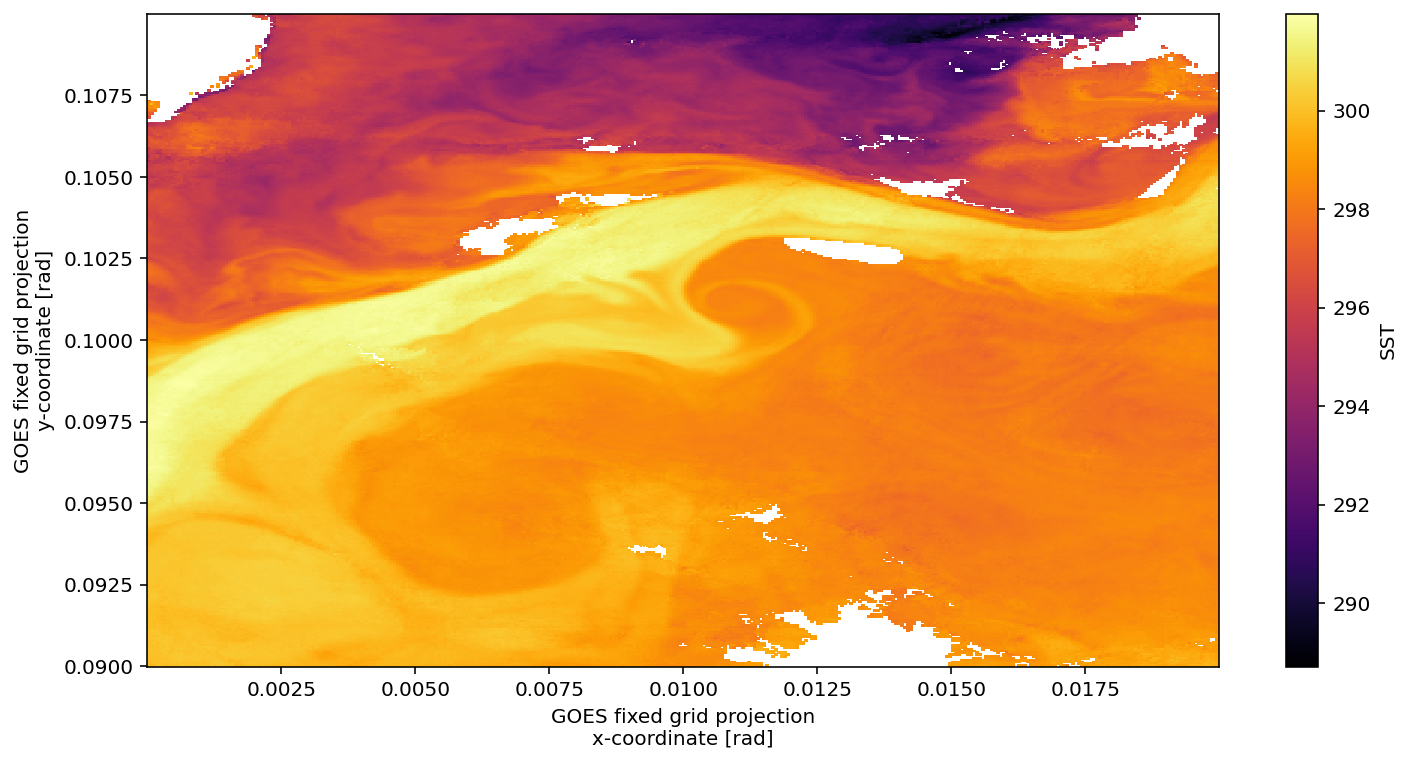

In [51]:
ds_subset = ds.isel(time=slice(0,24))
gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
mean_SST.plot(cmap='inferno')

In [52]:
from remap import remap
# Get the latitude and longitude image bounds
geo_extent = ds['geospatial_lat_lon_extent']
#print(geo_extent)
min_lon = geo_extent.geospatial_westbound_longitude
max_lon = geo_extent.geospatial_eastbound_longitude
min_lat = geo_extent.geospatial_southbound_latitude
max_lat = geo_extent.geospatial_northbound_latitude

# Choose the visualization extent (min lon, min lat, max lon, max lat)
#extent = [-85.0, -5.0, -60.0, 12.0]
extent = [min_lon, min_lat, max_lon, max_lat]
#print(extent)
# Choose the image resolution (the higher the number the faster the processing is)
resolution = 2.0 #Check from spatial_resolution attribute
 
# Calculate the image extent required for the reprojection
H = ds['goes_imager_projection'].perspective_point_height
x1 = ds['x_image_bounds'][0] * H
x2 = ds['x_image_bounds'][1] * H
y1 = ds['y_image_bounds'][1] * H
y2 = ds['y_image_bounds'][0] * H


fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!
syr = 2020
sjdy = 210
path,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+str(syr)+'/'+str(sjdy)+'/*/*.nc'),'SST'
print(path[1])
# Call the reprojection funcion
#grid = remap(path, extent, resolution, x1, y1, x2, y2)
ds2

noaa-goes16/ABI-L2-SSTF/2020/210/01/OR_ABI-L2-SSTF-M6_G16_s20202100100205_e20202100159512_c20202100205423.nc


<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates:
    t                                                       datetime64[ns] 20...
  * y                                                       (y) float32 0.151...
  * x                                                       (x) float32 -0.15...
    y_image                                                 float32 0.0
    x_image                                                 float32 0.0
    retrieval_local_zenith_angle                            float32 90.0
    quantitative_local_zenith_angle                         float32 67.0
    retrieval_solar_zenith_angle                            float32 180.0
    day_solar_zenith_angle                                  float32 85.0
    night_solar_zenith_angle                                float32 95.0
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 ...
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 ...
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 ...
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 ...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    SST                                                     (y, x) float32 ...
    DQF                                                     (y, x) float32 ...
    time_bounds                                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                                  int32 -2147483647
    y_image_bounds                                          (number_of_image_bounds) float32 ...
    x_image_bounds                                          (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                          float64 0.0
    nominal_satellite_subpoint_lon                          float64 -75.2
    nominal_satellite_height                                float64 3.579e+04
    geospatial_lat_lon_extent                               float32 9.96921e+36
    total_number_of_good_quality_ocean_pixels               float64 3.925e+06
    total_number_of_degraded_quality_ocean_pixels           float64 5.727e+05
    total_number_of_severely_degraded_quality_ocean_pixels  float64 1.237e+07
    total_number_of_unprocessed_pixels                      float64 1.256e+07
    number_of_day_SST_pixels                                float64 7.664e+05
    number_of_night_SST_pixels                              float64 2.145e+06
    number_of_twilight_SST_pixels                           float64 1.1e+07
    sea_surface_temp_outlier_pixel_count                    float64 1.774e+06
    minimum_sea_surface_temp                                float64 192.3
    maximum_sea_surface_temp                                float64 317.7
    mean_sea_surface_temp                                   float64 286.4
    standard_deviation_sea_surface_temp                     float64 16.12
    min_obs_modeled_diff_SST_night_only_emissive_band       float64 -5.617
    max_obs_modeled_diff_SST_night_only_emissive_band       float64 5.511
    mean_obs_modeled_diff_SST_night_only_emissive_band      float64 -0.2118
    std_dev_obs_modeled_diff_SST_night_only_emissive_band   float64 0.4426
    min_retrieved_Reynolds_SST_diff                         float64 -3.041
    max_retrieved_Reynolds_SST_diff                         float64 14.68
    mean_retrieved_Reynolds_SST_diff                        float64 0.08234
    std_dev_retrieved_Reynolds_SST_diff                     float64 0.2882
    algori

In [57]:
# Load the Data =======================================================================================
# Path to the GOES-16 image file
fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!
syr = 2020
sjdy = 210
path,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+str(syr)+'/'+str(sjdy)+'/*/*.nc'),'SST'
path=path[0]
#path = 'E:\\VLAB\\Python\\GOES-16 Samples\\OR_ABI-L2-CMIPC-M3C13_G16_s20172910057131_e20172910059515_c20172910059556.nc'
 
# Getting information from the file name ==============================================================
# Search for the Scan start in the file name
Start = (path[path.find("_s")+2:path.find("_e")])
# Search for the GOES-16 channel in the file name
#Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
Band = np.append(ds.SST_night_only_emissive_band_id.values[0], ds.SST_day_night_emissive_band_ids.values[0,:])
# Create a GOES-16 Bands string array
Wavelenghts = ds.SST_day_night_emissive_wavelengths.values[0] #['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
 
# Converting from julian day to dd-mm-yyyy
year = int(Start[0:4])
dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
 
time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
 
# Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
if np.nanmin(Band) <= 6:
 Unit = "Reflectance"
else:
 Unit = "Brightness Temperature [°C]"
 
# Choose a title for the plot
#Title = " GOES-16 ABI CMI Band " + str(Band) + " " + Wavelenghts[int(Band)] + " " + Unit + " " + date + " " + time
# Insert the institution name
#Institution = "GNC-A Blog"
# =====================================================================================================
 
# Open the file using the NetCDF4 library
#nc = Dataset(path)
#file_ob = fs.open(path)
#ds2 = xr.open_dataset(file_ob)
 
# Get the latitude and longitude image bounds
geo_extent = ds['geospatial_lat_lon_extent']
#print(geo_extent)
min_lon = geo_extent.geospatial_westbound_longitude
max_lon = geo_extent.geospatial_eastbound_longitude
min_lat = geo_extent.geospatial_southbound_latitude
max_lat = geo_extent.geospatial_northbound_latitude
 
# Choose the visualization extent (min lon, min lat, max lon, max lat)
#extent = [-85.0, -5.0, -60.0, 12.0]
extent = [min_lon, min_lat, max_lon, max_lat]
 
# Choose the image resolution (the higher the number the faster the processing is)
resolution = 2.0
 
H = ds['goes_imager_projection'].perspective_point_height
x1 = ds['x_image_bounds'][0] * H
x2 = ds['x_image_bounds'][1] * H
y1 = ds['y_image_bounds'][1] * H
y2 = ds['y_image_bounds'][0] * H
 
# Call the reprojection funcion
grid = remap(path, extent, resolution, x1, y1, x2, y2)

 
# Read the data returned by the function
if Band <= 6:
 data = grid.ReadAsArray()
else:
 # If it is an IR channel subtract 273.15 to convert to ° Celsius
 data = grid.ReadAsArray() - 273.15
#======================================================================================================
 
# Define the size of the saved picture=================================================================
DPI = 150
ax = plt.figure(figsize=(2000/float(DPI), 2000/float(DPI)), frameon=True, dpi=DPI)
#======================================================================================================
 

FileNotFoundError: [Errno 2] No such file or directory: b'noaa-goes16/ABI-L2-SSTF/2020/210/00/OR_ABI-L2-SSTF-M6_G16_s20202100000205_e20202100059513_c20202100105456.nc'

In [ ]:
# Plot the Data =======================================================================================
# Create the basemap reference for the Rectangular Projection
bmap = Basemap(llcrnrlon=extent[0], llcrnrlat=extent[1], urcrnrlon=extent[2], urcrnrlat=extent[3], epsg=4326)
 
# Draw the countries and Brazilian states shapefiles
bmap.readshapefile('E:\\VLAB\\Python\\Shapefiles\\BRA_adm1','BRA_adm1',linewidth=0.50,color='cyan')
bmap.readshapefile('E:\\VLAB\Python\\Shapefiles\\ne_10m_admin_0_countries','ne_10m_admin_0_countries',linewidth=0.50,color='cyan')
 
# Draw parallels and meridians
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.2, dashes=[4, 4], color='white', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.0), linewidth=0.2, dashes=[4, 4], color='white', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)
 
if Band 7 and Band 10:
 # Converts a CPT file to be used in Python
 cpt = loadCPT('E:\\VLAB\\Python\\Colortables\\IR4AVHRR6.cpt')
 # Makes a linear interpolation
 cpt_convert = LinearSegmentedColormap('cpt', cpt)
 # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
 bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-103, vmax=84)
 
if Band <= 6:
 # Insert the colorbar at the bottom
 cb = bmap.colorbar(location='bottom', size = '2%', pad = '-4.2%', ticks=[0.2, 0.4, 0.6, 0.8])
 cb.ax.set_xticklabels(['0.2', '0.4', '0.8', '0.8'])
else:
 # Insert the colorbar at the bottom
 cb = bmap.colorbar(location='bottom', size = '2%', pad = '-4.2%')
 
cb.outline.set_visible(False) # Remove the colorbar outline
cb.ax.tick_params(width = 0) # Remove the colorbar ticks
cb.ax.xaxis.set_tick_params(pad=-9.5) # Put the colobar labels inside the colorbar
cb.ax.tick_params(axis='x', colors='yellow', labelsize=6) # Change the color and size of the colorbar labels
 
# Add a black rectangle in the bottom to insert the image description
lon_difference = (extent[2] - extent[0]) # Max Lon - Min Lon
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((extent[0], extent[1]), lon_difference, lon_difference * 0.010, alpha=1, zorder=3, facecolor='black'))
 
# Add the image description inside the black rectangle
lat_difference = (extent[3] - extent[1]) # Max lat - Min lat
plt.text(extent[0], extent[1] + lat_difference * 0.003,Title,horizontalalignment='left', color = 'white', size=7)
plt.text(extent[2], extent[1] + lat_difference * 0.003,Institution, horizontalalignment='right', color = 'yellow', size=7)
 
# Add logos / images to the plot
logo_INPE = plt.imread('E:\\VLAB\\Python\\Logos\\INPE Logo.png')
logo_NOAA = plt.imread('E:\\VLAB\\Python\\Logos\\NOAA Logo.png')
logo_GOES = plt.imread('E:\\VLAB\\Python\\Logos\\GOES Logo.png')
ax.figimage(logo_INPE, 10, 40, zorder=3, alpha = 1, origin = 'upper')
ax.figimage(logo_NOAA, 110, 40, zorder=3, alpha = 1, origin = 'upper')
ax.figimage(logo_GOES, 195, 40, zorder=3, alpha = 1, origin = 'upper')
 
date_save = dayconventional.strftime('%d%m%Y')
time_save = Start [7:9] + Start [9:11] + Start [11:13]
 
# Save the result
plt.savefig('E:\\VLAB\\Python\\Output\\G16_C' + str(Band) + '_' + date_save + '_' + time_save + '.png', dpi=DPI, bbox_inches='tight', pad_inches=0)
#======================================================================================================
